In [1]:
import batoid
import galsim
import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%autoreload 2

In [2]:
filename = os.path.join(batoid.datadir, 'HSC', 'HSC.yaml')
config = yaml.load(open(filename))
fiducial_telescope = batoid.parse.parse_optic(config['opticalSystem'])

In [3]:
# Make an fft PSF
paraxialFFT = batoid.fftPSF(fiducial_telescope, 0.01, 0.0, 750e-9, nx=64, pad_factor=4, paraxial=True)
plt.imshow(paraxialFFT.array)
plt.colorbar()
print(paraxialFFT.primitiveVectors*1e6/15) # units of HSC pixels
dGnomicDx = batoid.psf.dthdr(fiducial_telescope, 0.01, 0.0, 750e-9)
dSphericalDGnomic = batoid.utils.dSphericalDGnomic(0.01, 0.0)
paraxialFFTSphericalPrimitives = np.dot(
    np.dot(
        paraxialFFT.primitiveVectors,
        dGnomicDx
    ),
    dSphericalDGnomic
) * 206265  # arcsec
print(paraxialFFTSphericalPrimitives)

TypeError: fftPSF() got an unexpected keyword argument 'paraxial'

[[ -2.94857667e-02   2.57650281e-08]
 [  8.78776965e-09  -2.84282064e-02]]
[[ -4.71600887e-03   1.08917574e-08]
 [  8.32921096e-08  -4.71642909e-03]]


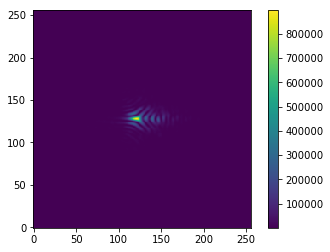

In [74]:
# Make an fft PSF
nonParaxialFFT = batoid.fftPSF(fiducial_telescope, 0.01, 0.0, 750e-9, nx=64, pad_factor=4)
plt.imshow(nonParaxialFFT.array)
plt.colorbar()
print(nonParaxialFFT.primitiveVectors*1e6/15) # units of HSC pixels
nonParaxialFFTSphericalPrimitives = np.dot(
    np.dot(
        nonParaxialFFT.primitiveVectors,
        dGnomicDx
    ),
    dSphericalDGnomic
) * 206265  # arcsec
print(nonParaxialFFTSphericalPrimitives)

[[ -2.94857667e-02   2.57650281e-08]
 [  8.78776965e-09  -2.84282064e-02]]
[[ -4.71600887e-03   1.08917574e-08]
 [  8.32921096e-08  -4.71642909e-03]]


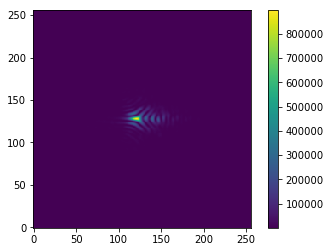

In [75]:
# Huygens, on the same grid as nonParaxialFFT
huygens = batoid.huygensPSF(fiducial_telescope, 0.01, 0.0, 750e-9, 
                            nx=64,
                            nxOut=256,
                            dx=nonParaxialFFT.primitiveVectors[0],
                            dy=nonParaxialFFT.primitiveVectors[1])
plt.imshow(huygens.array)
plt.colorbar()
print(huygens.primitiveVectors*1e6/15)
huygensSphericalPrimitives = np.dot(
    np.dot(
        huygens.primitiveVectors,
        dGnomicDx
    ),
    dSphericalDGnomic
) * 206265  # arcsec
print(huygensSphericalPrimitives)

[[ -2.79490793e-02   2.73644472e-18]
 [  5.43979110e-18  -2.79490793e-02]]
[[ -4.47022821e-03   6.27230546e-09]
 [  8.05064664e-08  -4.63693871e-03]]


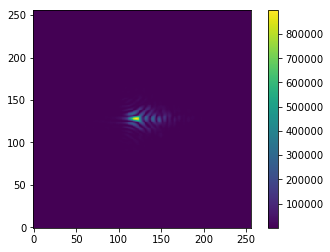

In [76]:
# Huygens, but evaluated at the same positions as paraxial
huygensParaxial = batoid.huygensPSF(fiducial_telescope, 0.01, 0.0, 750e-9, 
                                    nx=64,
                                    nxOut=256,
                                    dx=paraxialFFT.primitiveVectors[0],
                                    dy=paraxialFFT.primitiveVectors[1])
plt.imshow(huygensParaxial.array)
plt.colorbar()
print(huygensParaxial.primitiveVectors*1e6/15)
huygensParaxialSphericalPrimitives = np.dot(
    np.dot(
        huygensParaxial.primitiveVectors,
        dGnomicDx
    ),
    dSphericalDGnomic
) * 206265  # arcsec
print(huygensParaxialSphericalPrimitives)

In [77]:
# First, let's just plot normalized differences

# By construction.  Difference is the anisotropic pixel scale.
np.testing.assert_allclose(paraxialFFT.array, nonParaxialFFT.array)

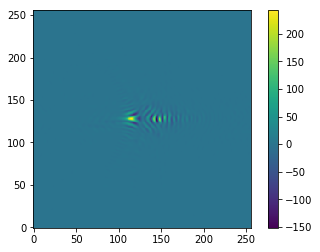

In [78]:
plt.imshow(huygens.array - nonParaxialFFT.array)
plt.colorbar()

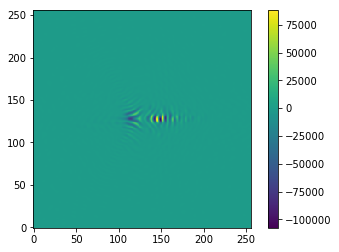

In [79]:
plt.imshow(paraxialFFT.array - huygensParaxial.array)
plt.colorbar()

In [84]:
# Now we can form galsim objects and project onto the same sky.
paraxialFFTObj = galsim.InterpolatedImage(
    galsim.Image(
        paraxialFFT.array, 
        wcs=galsim.JacobianWCS(*paraxialFFTSphericalPrimitives.ravel())
    ),
    normalization='sb',
    flux=1
)

nonParaxialFFTObj = galsim.InterpolatedImage(
    galsim.Image(
        nonParaxialFFT.array,
        wcs=galsim.JacobianWCS(*nonParaxialFFTSphericalPrimitives.ravel())
    ),
    normalization='sb',
    flux=1
)

huygensObj = galsim.InterpolatedImage(
    galsim.Image(
        huygens.array,
        wcs=galsim.JacobianWCS(*huygensSphericalPrimitives.ravel())
    ),
    normalization='sb',
    flux=1
)

huygensParaxialObj = galsim.InterpolatedImage(
    galsim.Image(
        huygensParaxial.array,
        wcs = galsim.JacobianWCS(*huygensParaxialSphericalPrimitives.ravel())
    ),
    normalization='sb',
    flux=1
)

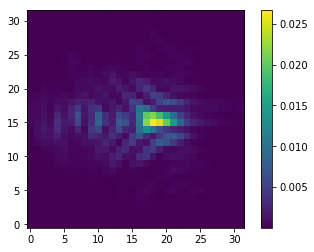

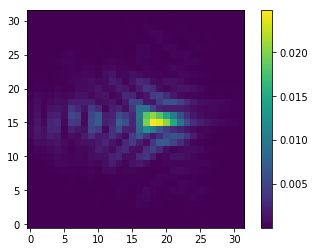

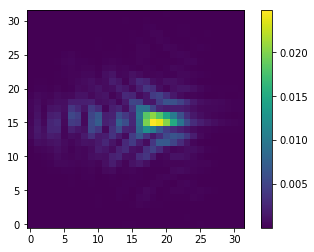

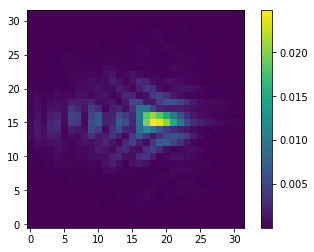

In [97]:
parFFTImg = paraxialFFTObj.drawImage(scale=0.01, nx=32, ny=32)
plt.imshow(parFFTImg.array)
plt.colorbar()
plt.show()

nonParFFTImg = nonParaxialFFTObj.drawImage(scale=0.01, nx=32, ny=32)
plt.imshow(nonParFFTImg.array)
plt.colorbar()
plt.show()

hImg = huygensObj.drawImage(scale=0.01, nx=32, ny=32)
plt.imshow(hImg.array)
plt.colorbar()
plt.show()

hParImg = huygensParaxialObj.drawImage(scale=0.01, nx=32, ny=32)
plt.imshow(hParImg.array)
plt.colorbar()
plt.show()